# Contraceptive Method Prediction Model

In this section, we will build a model to predict which contraceptive method will be given to an individual. We will begin by importing the necessary libraries for data manipulation, visualization, feature selection, and model building.

Key steps in the process will include:

- **Data Preprocessing**: Encoding categorical variables, feature scaling, and handling class imbalances.
- **Model Building**: We will experiment with various classification algorithms such as Random Forest, Support Vector Machines (SVM), K-Nearest Neighbors (KNN), and XGBoost.
- **Model Evaluation**: We will evaluate model performance using accuracy, confusion matrix, ROC curve, and AUC score.

Let's start by importing the required libraries.


In [1]:

import pandas as pd
import numpy as np
       
import matplotlib.pyplot as plt  
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Data Loading and Initial Inspection

In this step, we will load the dataset and perform an initial inspection to understand its structure. We'll check the shape of the data (number of rows and columns) and get an overview of the data types .

Let's start by loading the dataset and displaying some basic information about it.


In [2]:
df=pd.read_csv("C:/Users/COCOCE/final_family_planning_data.csv")
print(df.shape)
df.info()

(2534, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       2534 non-null   int64  
 1   children_in_life                 2534 non-null   float64
 2   desired_number_of_children       2534 non-null   float64
 3   number_of_children_died          2534 non-null   float64
 4   duration_of_utilization          2534 non-null   float64
 5   the_period_the_method_will_last  2534 non-null   float64
 6   age                              2534 non-null   float64
 7   time_since_lmp                   2534 non-null   float64
 8   family_plan_method_used          2534 non-null   object 
 9   desired_method                   2534 non-null   object 
 10  company                          2534 non-null   object 
 11  district                         2534 non-null   object 
 12  accompani

# Exploring the Target Variable: Contraceptive Method Distribution

In this step, we will explore the distribution of the target variable, `method_chosen_category`, which represents the contraceptive method chosen by individuals. We will calculate both the counts and the percentages of each category.

This will help us understand the class distribution and check if there is any imbalance in the dataset.

Let's calculate the counts and percentages for each contraceptive method.


In [3]:
df['method_chosen_category'].value_counts()# Get counts and percentages
counts = df['method_chosen_category'].value_counts()
percentages = df['method_chosen_category'].value_counts(normalize=True) * 100

# Combine into a DataFrame
method_summary = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages.round(2)
})

print(method_summary)


                                Count  Percentage (%)
method_chosen_category                               
Hormonal - Injectable            1319           52.05
Hormonal - Oral Pills             780           30.78
Hormonal - implant                315           12.43
Non-Hormonal or Hormonal - IUD     82            3.24
Others                             38            1.50


### The baseline accuracy is 52.05%

# Defining Numeric and Categorical Columns

In this step, we will define the columns for the dataset that will be categorized as numeric and categorical. 

- **Numeric Columns**: These are continuous variables that represent quantities or measurements.
- **Categorical Columns**: These represent categories or classes that are not numerical, such as marital status or education level.
  
We will also define the target column (`method_chosen_category`), which is the variable we are trying to predict.

Let's define these columns to prepare for further data processing and model building.


In [4]:
# 1. Define columns
numeric_columns = [
     'children_in_life', 
     'desired_number_of_children',
     'number_of_children_died',
     'duration_of_utilization',
     'the_period_the_method_will_last',
     'age',
     'time_since_lmp'
]

categorical_columns = [
   
    'family_plan_method_used',
    'desired_method',
    'company',
    'district',
    'accompanied_by_partner',
    'profession_category',
    'marital_status',
    'province',
    'birth_limitation',
    'discharging',
    'education_level'
]

target_column = 'method_chosen_category'


# Data Preprocessing: Encoding and Scaling

In this step, we will preprocess the dataset by performing the following tasks:

1. **Feature Selection**: We select the categorical and numeric columns for model training.
2. **Label Encoding**: We apply label encoding to categorical features, converting them into numerical values.
3. **Feature Scaling**: We standardize the numeric features to ensure that all features have the same scale, which is important for models SVM, and KNN.
4. **Target Encoding**: We apply label encoding to the target variable (`method_chosen_category`) to convert it into a numerical format suitable for classification.
5. **Class Imbalance Handling**: We apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution in the training set.

This process ensures that the data is ready for model building and evaluation. We will also split the data into training and testing sets to avoid data leakage and perform the resampling only on the training set.




In [5]:

features = categorical_columns + numeric_columns
target = target_column
X = df[features]
y = df[target]


# Create a new copy of X to avoid modifying the original dataframe
X_encoded = X.copy()

print("Preprocessing data...")
# Apply label encoding to each categorical column
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X_encoded[col] = label_encoders[col].fit_transform(X[col])

# Scale numeric features for better performance
scaler = StandardScaler()
for col in numeric_columns:
    X_encoded[col] = scaler.fit_transform(X_encoded[col].values.reshape(-1, 1))

#Label Encode Target 
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Create and print a mapping between encoded and original class values
target_mapping = {i: label for i, label in enumerate(target_encoder.classes_)}
print("\nTarget Class Mapping (after encoding):")
for encoded_val, original_val in target_mapping.items():
    print(f"Encoded Class {encoded_val} -> Original Class: '{original_val}'")

# Check Initial Class Distribution 
class_counts = Counter(y_encoded)
print("\nInitial Class Distribution:")
for class_val, count in class_counts.items():
    print(f"Class '{target_mapping[class_val]}' (encoded as {class_val}): {count} samples ({count/len(y_encoded):.2%})")


# Important: Split before applying SMOTE to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Save original distribution for comparison
print("\nTraining set class distribution before SMOTE:")
train_class_counts = Counter(y_train)
for class_val, count in train_class_counts.items():
    print(f"Class '{target_mapping[class_val]}' (encoded as {class_val}): {count} samples ({count/len(y_train):.2%})")

# Apply SMOTE to handle class imbalance 
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("\nTraining set class distribution after SMOTE:")
resampled_class_counts = Counter(y_train_resampled)
for class_val, count in resampled_class_counts.items():
    print(f"Class '{target_mapping[class_val]}' (encoded as {class_val}): {count} samples ({count/len(y_train_resampled):.2%})")


Preprocessing data...

Target Class Mapping (after encoding):
Encoded Class 0 -> Original Class: 'Hormonal - Injectable'
Encoded Class 1 -> Original Class: 'Hormonal - Oral Pills'
Encoded Class 2 -> Original Class: 'Hormonal - implant'
Encoded Class 3 -> Original Class: 'Non-Hormonal or Hormonal - IUD'
Encoded Class 4 -> Original Class: 'Others'

Initial Class Distribution:
Class 'Hormonal - Injectable' (encoded as 0): 1319 samples (52.05%)
Class 'Hormonal - implant' (encoded as 2): 315 samples (12.43%)
Class 'Hormonal - Oral Pills' (encoded as 1): 780 samples (30.78%)
Class 'Non-Hormonal or Hormonal - IUD' (encoded as 3): 82 samples (3.24%)
Class 'Others' (encoded as 4): 38 samples (1.50%)

Training set class distribution before SMOTE:
Class 'Hormonal - Injectable' (encoded as 0): 1055 samples (52.05%)
Class 'Hormonal - Oral Pills' (encoded as 1): 624 samples (30.78%)
Class 'Hormonal - implant' (encoded as 2): 252 samples (12.43%)
Class 'Others' (encoded as 4): 30 samples (1.48%)
Clas

# 1.Training K-Nearest Neighbors (KNN) Model

## Training K-Nearest Neighbors (KNN) Model

In this step, we will train a K-Nearest Neighbors (KNN) classifier with its default parameters on the resampled training dataset. 

We will then evaluate the model's performance by calculating its accuracy on both the training and testing sets. This will help us understand how well the model generalizes to unseen data.

Let’s train the KNN model and evaluate its performance.


In [6]:
print("\nTraining KNN model with default parameters...")

# Initialize KNN Classifier (default: n_neighbors=5)
knn_model = KNeighborsClassifier()

# Fit on the resampled training set
knn_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on both training and testing sets
knn_train_score = knn_model.score(X_train_resampled, y_train_resampled)
knn_test_score = knn_model.score(X_test, y_test)

print(f"KNN - Training accuracy: {knn_train_score:.4f}")
print(f"KNN - Testing accuracy: {knn_test_score:.4f}")



Training KNN model with default parameters...
KNN - Training accuracy: 0.9663
KNN - Testing accuracy: 0.8185


<Figure size 800x800 with 0 Axes>

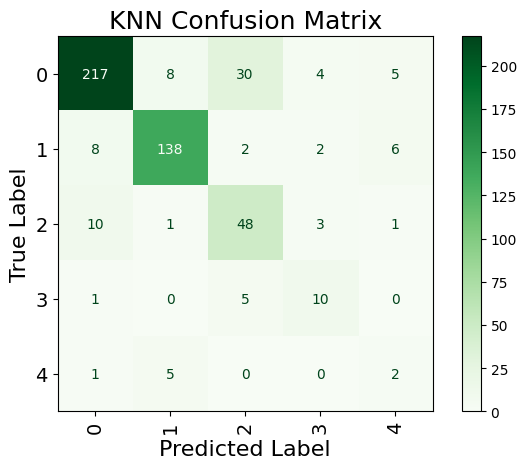

In [7]:
# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 8))
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                                  display_labels=[0,1,2,3,4])
disp_knn.plot(cmap='Greens', values_format='d', xticks_rotation='vertical')
plt.title("KNN Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
target_names = [
    "Hormonal - Injectable",
    "Hormonal - Oral Pills",
    "Hormonal - implant",
    "Non-Hormonal or Hormonal - IUD",
    "Others"
]


In [16]:
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=target_names))



KNN Classification Report:
                                precision    recall  f1-score   support

         Hormonal - Injectable       0.93      0.89      0.91       264
         Hormonal - Oral Pills       0.90      0.92      0.91       156
            Hormonal - implant       0.78      0.81      0.80        63
Non-Hormonal or Hormonal - IUD       0.60      0.75      0.67        16
                        Others       0.20      0.25      0.22         8

                      accuracy                           0.88       507
                     macro avg       0.68      0.72      0.70       507
                  weighted avg       0.88      0.88      0.88       507



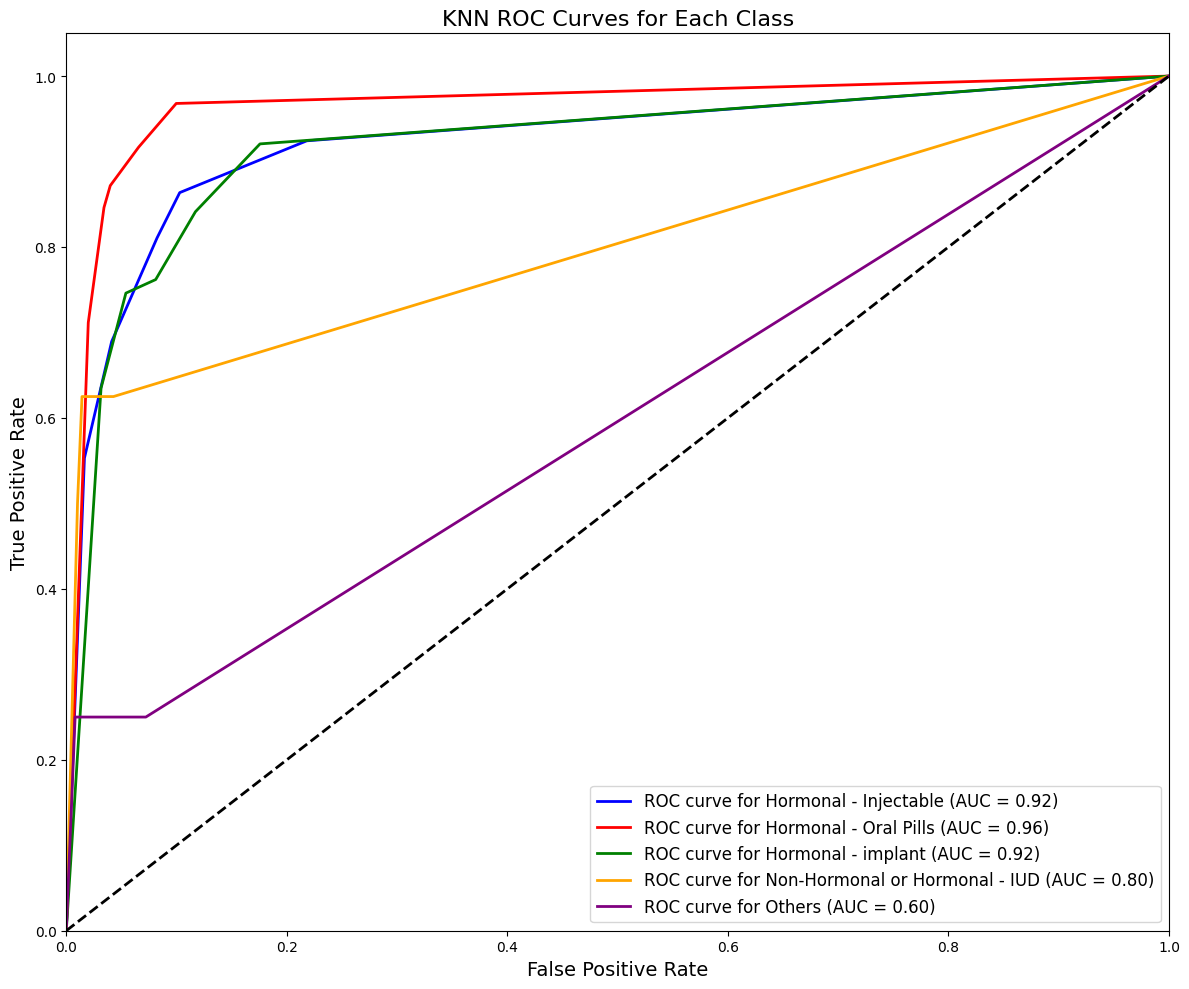

In [17]:

# Get probability predictions for ROC
y_score_knn = knn_model.predict_proba(X_test)

plt.figure(figsize=(12, 10))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
n_classes = len(np.unique(y_test))

for i, color in zip(range(n_classes), colors):
    if i >= len(target_encoder.classes_):
        break
    fpr, tpr, _ = roc_curve(y_test, y_score_knn[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f"ROC curve for {target_mapping[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('KNN ROC Curves for Each Class', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()


In [18]:
print("\nTuning KNN with GridSearchCV...")

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_train_resampled, y_train_resampled)

print("Best parameters for KNN:", grid_knn.best_params_)
print(f"Best CV Balanced Accuracy: {grid_knn.best_score_:.4f}")



Tuning KNN with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV Balanced Accuracy: 0.9655



Tuned KNN - Training Accuracy: 1.0000
Tuned KNN - Testing Accuracy: 0.8757


<Figure size 800x800 with 0 Axes>

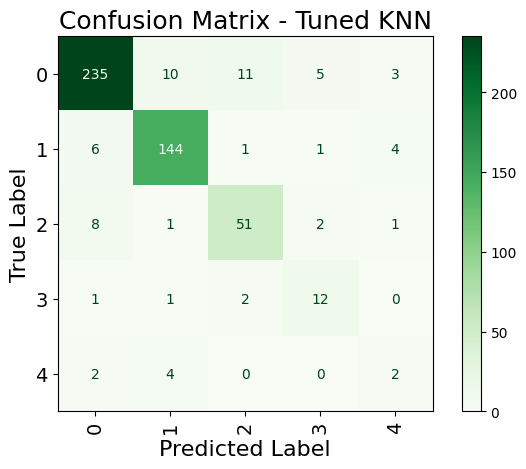


Classification Report - Tuned KNN:
                                precision    recall  f1-score   support

         Hormonal - Injectable       0.93      0.89      0.91       264
         Hormonal - Oral Pills       0.90      0.92      0.91       156
            Hormonal - implant       0.78      0.81      0.80        63
Non-Hormonal or Hormonal - IUD       0.60      0.75      0.67        16
                        Others       0.20      0.25      0.22         8

                      accuracy                           0.88       507
                     macro avg       0.68      0.72      0.70       507
                  weighted avg       0.88      0.88      0.88       507



In [26]:
# Use the best estimator from GridSearchCV
best_knn = grid_knn.best_estimator_

# Training and Testing Accuracy
knn_train_score = best_knn.score(X_train_resampled, y_train_resampled)
knn_test_score = best_knn.score(X_test, y_test)

print(f"\nTuned KNN - Training Accuracy: {knn_train_score:.4f}")
print(f"Tuned KNN - Testing Accuracy: {knn_test_score:.4f}")

# Predictions on test data
y_pred_knn = best_knn.predict(X_test)

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 8))
disp_knn = ConfusionMatrixDisplay(
    confusion_matrix=cm_knn,
    display_labels=[0,1,2,3,4]
)
disp_knn.plot(cmap='Greens', values_format='d', xticks_rotation='vertical')

plt.title("Confusion Matrix - Tuned KNN", fontsize=18)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Detailed Classification Report
print("\nClassification Report - Tuned KNN:")
print(classification_report(y_test, y_pred_knn, target_names=target_names))


In [27]:
# ROC AUC Score
knn_auc_score = roc_auc_score(y_test_bin, y_score, multi_class='ovr')
print(f"\nTuned KNN - ROC AUC Score (OvR): {knn_auc_score:.4f}")

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - Tuned KNN', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
# Get feature names if available
try:
    feature_names = X.columns  # If X is a DataFrame
except:
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Compute permutation importance
result = permutation_importance(
    best_knn, X_test, y_test, 
    n_repeats=30,
    random_state=42,
    scoring='balanced_accuracy'
)

# Sort results
sorted_idx = result.importances_mean.argsort()

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], 
         xerr=result.importances_std[sorted_idx], align='center', color='teal')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], fontsize=12)
plt.xlabel("Permutation Importance (Balanced Accuracy Decrease)", fontsize=14)
plt.title("Feature Importance - Tuned KNN (Permutation)", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2.XGBoost model

## Training an Unfine-Tuned XGBoost Model

Next, we train an XGBoost classifier using the default parameters to establish a baseline for performance. XGBoost is a powerful gradient boosting algorithm known for its speed and accuracy.

We will:
- Train the model on the resampled training set.
- Evaluate accuracy on both the training and testing sets.
- Visualize the confusion matrix to see how well the model classifies each category.
- Generate a classification report for a more detailed performance analysis (precision, recall, F1-score).

Let’s train and evaluate the unfine-tuned XGBoost model.


In [ ]:
# Initialize default XGBoost model
xgb_default = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Fit the model
xgb_default.fit(X_train_resampled, y_train_resampled)

# Training and testing accuracy
train_acc_default = xgb_default.score(X_train_resampled, y_train_resampled)
test_acc_default = xgb_default.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_acc_default:.4f}")
print(f"Testing Accuracy: {test_acc_default:.4f}")

# Predictions
y_pred_default = xgb_default.predict(X_test)

# Confusion Matrix
cm_default = confusion_matrix(y_test, y_pred_default)

plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay(cm_default, display_labels=[0,1,2,3,4]).plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix - Unfine-Tuned XGBoost", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - Unfine-Tuned XGBoost:")
print(classification_report(y_test, y_pred_default, target_names=target_names))


# Hyperparameter Tuning for XGBoost using GridSearchCV

To improve the performance of our initial XGBoost model, we perform hyperparameter tuning using `GridSearchCV`. This process systematically tests multiple combinations of model parameters to find the best-performing configuration.

The parameters we are tuning include:
- `n_estimators`: Number of boosting rounds
- `max_depth`: Maximum depth of trees
- `learning_rate`: Step size shrinkage
- `subsample`: Fraction of training samples used per tree
- `colsample_bytree`: Fraction of features used per tree

We use 5-fold cross-validation and optimize based on **balanced accuracy**, which is suitable for imbalanced classification tasks.

Let's find the optimal parameters for our XGBoost model.


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
print("\nTuning XGBoost with GridSearchCV...")

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train_resampled, y_train_resampled)

print("Best parameters for XGBoost:", grid_xgb.best_params_)
print(f"Best CV Balanced Accuracy: {grid_xgb.best_score_:.4f}")


In [ ]:
best_xgb = grid_xgb.best_estimator_

# Accuracy
train_acc_tuned = best_xgb.score(X_train_resampled, y_train_resampled)
test_acc_tuned = best_xgb.score(X_test, y_test)

print(f"\nFine-Tuned XGBoost - Training Accuracy: {train_acc_tuned:.4f}")
print(f"Fine-Tuned XGBoost - Testing Accuracy: {test_acc_tuned:.4f}")

# Predictions
y_pred_tuned = best_xgb.predict(X_test)

# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay(cm_tuned, display_labels=[0,1,2,3,4]).plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix - Fine-Tuned XGBoost", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report - Fine-Tuned XGBoost:")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))


In [ ]:

# 1. Binarize y_test for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# 2. Predict probabilities for both models
y_proba_default = xgb_default.predict_proba(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)

# 3. AUC Scores

auc_tuned = roc_auc_score(y_test_bin, y_proba_tuned, multi_class='ovr')


print(f"🔹 AUC - Fine-Tuned XGBoost: {auc_tuned:.4f}")

# 4. Plot ROC Curves for Fine-Tuned XGBoost
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_tuned[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Fine-Tuned XGBoost (One-vs-Rest)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Feature Importances
importances = best_xgb.feature_importances_

# Creating a DataFrame for the features and their importances
features = X_train_resampled.columns  # Assuming your X_train is a DataFrame with feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sorting the DataFrame based on importance
importance_df = importance_df.sort_values(by='Importance')

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='orange')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importances - Fine-Tuned XGBoost', fontsize=16)
plt.tight_layout()
plt.show()

# 3.Random Forest Classifier

## Baseline Random Forest Classifier

Next, we build a baseline **Random Forest** model using default hyperparameters. Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs to improve predictive performance and control overfitting.

Steps performed:
- Train a `RandomForestClassifier` on the SMOTE-resampled training set.
- Evaluate the model using:
  - Accuracy on training and test sets
  - Confusion matrix visualization
  - Classification report with precision, recall, and F1-score

This will give us a performance benchmark before applying any tuning to the model.


In [ ]:
# Binarize test labels for AUC and ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]


print("Unfine-Tuned Random Forest")

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_resampled, rf.predict(X_train_resampled)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Confusion Matrix
conf_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Unfine-Tuned RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report - Unfine-Tuned RF:")
print(classification_report(y_test, y_pred_rf))



## Fine-Tuning Random Forest Classifier

To improve the performance of the baseline Random Forest model, we apply **hyperparameter tuning** using `GridSearchCV`. The grid search explores combinations of the following parameters:
- `n_estimators`: Number of trees in the forest
- `max_depth`: Maximum depth of each tree
- `min_samples_split`: Minimum number of samples required to split an internal node
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node

After finding the best combination using 5-fold cross-validation with `balanced_accuracy` as the scoring metric, we:
- Refit the model on the training data
- Evaluate on the test data using accuracy, confusion matrix, and classification report
- Calculate the **multi-class AUC score** using `roc_auc_score` for further insight into model performance


In [ ]:
print("\n Fine-Tuning Random Forest with GridSearchCV...")

param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", grid_rf.best_params_)

# Fit best model
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)

# Accuracy
print(f"Train Accuracy: {accuracy_score(y_train_resampled, best_rf.predict(X_train_resampled)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")

# Confusion Matrix
conf_best_rf = confusion_matrix(y_test, y_pred_best_rf)
sns.heatmap(conf_best_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Fine-Tuned RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report - Fine-Tuned RF:")
print(classification_report(y_test, y_pred_best_rf))

# AUC Score
auc_best_rf = roc_auc_score(y_test_bin, y_proba_best_rf, multi_class='ovr')
print(f"AUC Score (Fine-Tuned RF): {auc_best_rf:.4f}")


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_best_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fine-Tuned Random Forest')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature Importances
importances_rf = best_rf.feature_importances_

# Creating a DataFrame for the features and their importances
features_rf = X_train_resampled.columns  # Assuming your X_train is a DataFrame with feature names
importance_df_rf = pd.DataFrame({'Feature': features_rf, 'Importance': importances_rf})

# Sorting the DataFrame based on importance
importance_df_rf = importance_df_rf.sort_values(by='Importance')

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df_rf['Feature'], importance_df_rf['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importances - Fine-Tuned Random Forest', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#  Initial (Un-tuned) Support Vector Machine 
print("\nTraining Initial SVM Model...")
svm = SVC(random_state=42, probability=True)  # 'probability=True' for AUC calculation
svm.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)

# Metrics for the un-tuned model
train_acc_svm = accuracy_score(y_train_resampled, svm.predict(X_train_resampled))
test_acc_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
clf_report_svm = classification_report(y_test, y_pred_svm)
auc_score_svm = roc_auc_score(y_test_bin, y_proba_svm, multi_class='ovr')

# Output Initial Metrics
print(f"Initial SVM Model - Training Accuracy: {train_acc_svm:.4f}")
print(f"Initial SVM Model - Testing Accuracy: {test_acc_svm:.4f}")
print("\nConfusion Matrix (Initial SVM):")
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Initial SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report (Initial SVM):")
print(clf_report_svm)

print(f"\nAUC Score (Initial SVM): {auc_score_svm:.4f}")